<a href="https://colab.research.google.com/github/AeneasWeiChiHsu/AeneasWeiChiHsu/blob/main/DQN_CarRacing_RL_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️ **不要熬夜寫code。**

# Introduction: Double Duel DQN on Car Racing v3

這個版本是model 2 往上升級。

**升級點：epsilon調控。**

> 因為我不會開車，所以我決定訓練一個Agent來開車。

本集特別感謝：IBM 在 Coursera 上的線上課程 [Deep Learning with Keras and TensorFlow](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/home)

詳細內容請參考：[Building a Deep Q-Network with Keras](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/ungradedLti/AlszB/lab-building-a-deep-q-network-with-keras)

本集特別感謝：University of Alberta 在 Coursera 上的線上課程 [Fundamentals of Reinforcement Learning](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/home)


# Goal: Deep Q-Network with Keras

故事是這樣的，我之前上過一門課，叫做《控制理論》，但是內容都是在講 Reinforcement Learning。
不過那個時候我什麼都不懂，只是想要做完期末專題：CarRacing。
所以我在Github上面看到有人 share 了一段 DualDQN 的code，我覺得很棒，我就拿來改。
最後那個不是我的 Agent 幫我完成了我的 Final Project。
不過那段 Code 是用 pytorch 寫的。但是基於某些理由我不喜歡 pytorch。
現在我要做這個 Project。

## Box2D

請參考 OpenAI gymnasium 的說明來安裝相對應的東西
https://gymnasium.farama.org/environments/box2d/

In [1]:
# Instal Gym
!pip install gymnasium
! pip install swig
! pip install gymnasium[box2d]
# Install OpenCV
!pip install opencv-python

# ==== Note ====
# If you are run it in local jupyter lab, uncomment this line
#!pip install box2d pygame

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Model

# ==== Layers ====
from tensorflow.keras.layers import Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Activation, Lambda, Add, LayerNormalization, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Cropping2D, ZeroPadding1D, Cropping1D, Layer

# ==== Optimizer ====
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

# ==== Callbacks ====
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from tqdm import tqdm
from tqdm import trange
from collections import Counter
# ==== Video ====
import imageio
import os
import cv2 # Import cv2 here

# Environment

https://gymnasium.farama.org/environments/box2d/car_racing/

Actions = [do nothing, left, right, gas, brake]

Observation = **A top-down 96x96 RGB image of the car and race track.**


In [4]:
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)

env.close()

# Model

⬇️ 這邊使用 Duel DQN 的模型做法。所以會有兩個 head（Advanced、Value）。

另外，我們採用了 Stack Frame (RGB)，因此 CNN 的 Input 需要改成 96x96x12.

如果要用 Gray 就是 96x96x4。（3個RGB+1個Gray的Stacked Frame）

如果什麼都不做就是 96x96x3。（3個RGB）

➡️ 這邊不動模型


In [5]:
# ==== Build Model ====
# If you use stack frame, the input is (96, 96, 12)
# If you don't use stack frame, the input is (96, 96, 3)
def build_model (input_shape = (96, 96, 12), action_size = 5):
  inputs = Input(shape = input_shape)

  # Normalize pixel [0,255] → [0,1]
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  # ==== Convolution Layers ====
  # Don't use BatchNormalization()
  # 這邊可以把 16 → 32 變成 32 → 64
  # Input 96 → (96 - 8)/4 + 1 = 23
  x = Conv2D(16, (8, 8), strides=4, activation = None)(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  # ReLU or LeakyReLU
  x = LeakyReLU()(x)

  # Input 23 → (23 - 4)/2 + 1 = 10
  x = Conv2D(32, (4, 4), strides=2, activation = None)(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  x = ReLU()(x)

  # Input 10 → (10 - 3)/1 + 1 = 8
  x = Conv2D(64, (3, 3), strides=1, activation = None)(x)
  x = ReLU()(x)

  # Input 8 → (8 - 3)/1 + 1 = 6
  x = Conv2D(128, (3, 3), strides=1, activation = None)(x)
  x = ReLU()(x)

  # ==== Flaten ====
  x = Flatten()(x)

  # ==== Deep Layers ====
  x = Dense(512, activation='relu')(x)
  #x = Dropout(0.2)(x)

  x = Dense(256, activation='relu')(x)
  #x = Dropout(0.2)(x)

  #x = Dense(128, activation='relu')(x)

  #x = Dense(64, activation='relu')(x)

  # ==== Dueling DQN =====
  # Two head mechanism
  # Advantage Stream
  a = Dense(256, activation='relu', name = 'Adv_1')(x)
  a = Dense(128, activation='relu', name = 'Adv_2')(x)
  a = Dense(action_size)(a)


  # Value Stream
  v = Dense(256, activation='relu', name = 'Value_1')(x)
  v = Dense(128, activation='relu', name = 'Value_2')(x)
  v = Dense(1)(v)

  # ==== Output ====
  # Q-values for each discrete action
  # Output: q_values = [[12.3, 11.8, 9.5, 14.2, 13.0]]
  # The q_values of each action
  # i.e., Q(s, a = 0) = 12.3
  # i.e., Q(s, a =1) = 11.8
  #outputs = Dense(action_size, activation='linear', name = 'Q-values')(x)

  # ==== Dueling DQN Output ====
  # Q(s, a) = V(s) + (A(s, a) - mean(A(s, a')))
  # V(s) -> (batch_size, 1)
  # A(s, a) -> (batch_size, action_size)

  # ==== Output ====
  # Note: Remember add "output_shape = (None, action_size)"
  outputs = Lambda(lambda x: x[0] + (x[1] - tf.reduce_mean(x[1], axis=1, keepdims=True)), output_shape=(None, action_size))([v, a])

  # ==== Model Build ====
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate=0.00025), loss='huber')

  return model

# ==== Car Racing parameters ====
state_size = 96*96*12
action_size = 5

# ====
model = build_model(input_shape = (96, 96, 12), action_size = 5)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96,    │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 23, 23,    │     12,304 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 23, 23,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 10, 10,    │      8,224 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 10, 10,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 64)  │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 128) │     73,856 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 6, 6, 128) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,359,808 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Value_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Adv_2 (Dense)       │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ Value_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        645 │ Adv_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 5)   │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,670,582 (10.19 MB)

 Trainable params: 2,670,582 (10.19 MB)

 Non-trainable params: 0 (0.00 B)

# Implement the replay buffer (Memory)

⬇️ Memory 怎麼處理也是個學問。

這邊的做法是比較單純的做法。進階一點的做法在 Prioritized Replay 那邊。

如果沒有要用 Stack Frame + Prioritized Replay，就直接走這邊的 Memory 處理方式。


In [6]:
memory = deque(maxlen=10000)
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Epsilon Greedy Policy (Act)

➡️ epsilon control

我們進行所謂的 exploration - exploitation trade-off

這裡我們要進行 epsilon 的微調。

我試過的策略包括了：

定義 acton 的時候微調 epsilon。讓 rewards per episode 大於 300 的時候增加 agent 對環境的探索。
目標是克服 reward plateau。
最後的結果是在後期的training的時候變得比較穩定一些。

```
def act(state, rewards_per_episode):
    global total_steps
    
    short_term_reward_average = np.mean(rewards_per_episode[-10:])

    if len(rewards_per_episode) < 10:
      short_term_reward_average = -np.inf

    # ==== Modify Epsilon ====
    if short_term_reward_average < 300:
      eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      total_steps += 1
    elif short_term_reward_average >= 300:
      eps_threshold = 0.1
      total_steps += 1

    if np.random.rand() <= eps_threshold:
        return random.randrange(action_size)
    # Add batch dimension
    # state: (96, 96, 3)
    # state[np.newaxis, ...]: (1, 96, 96, 3)
    # CNN model input: (batch_size, 96, 96, 3)
    q_values = model.predict(state[np.newaxis, ...], verbose=0)
    return np.argmax(q_values[0])
```

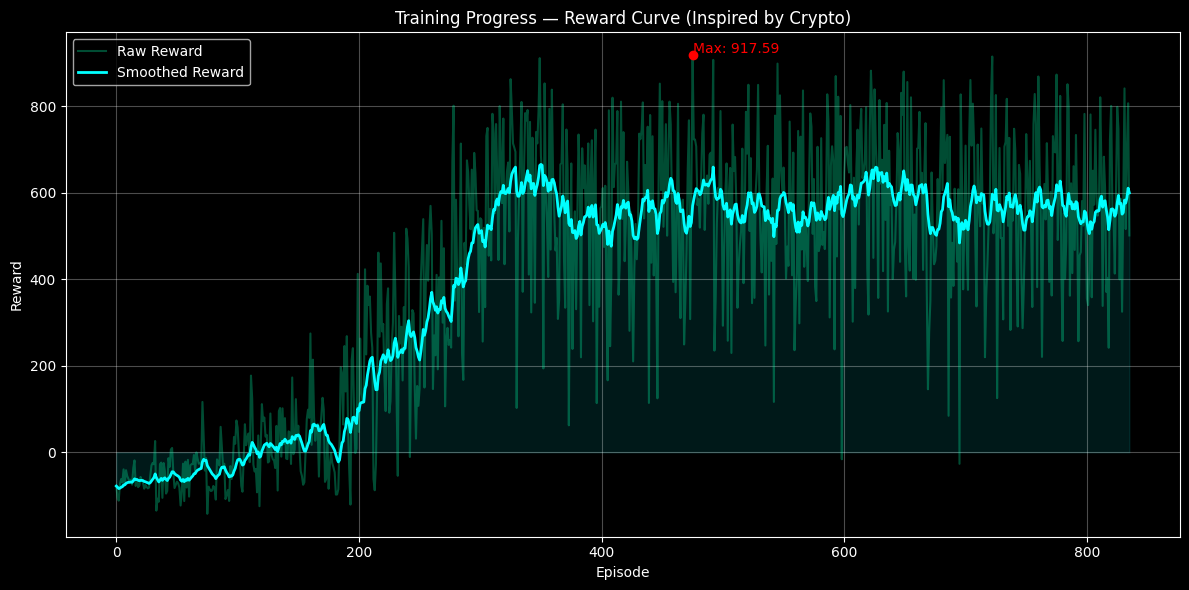



In [7]:
# ==== Epsilon Greedy Policy ====

# exploration rate
epsilon = 1.0
# minimum exploration rate
epsilon_min = 0.01
# dacay rate for epsilon after each episode
epsilon_decay =10000

epsilon_start = 1.0
epsilon_end = 0.05

total_steps = 0


# ==== Action ====
# act(): chooses an action based on the epsilon-greedy policy.
def act(state, rewards_per_episode):
    global total_steps

    # ==== Calculate the episode =====
    episode = len(rewards_per_episode)

    # short_term_reward_average = np.mean(rewards_per_episode[-10:])

    # ==== Modify Epsilon ====
    if episode < 500:
      eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      total_steps += 1
    else:
      # Randomly choice epsilon from epsilon_end to 0.2
      eps_threshold = np.random.uniform(epsilon_end, 0.2)
      total_steps += 1

    if np.random.rand() <= eps_threshold:
        return random.randrange(action_size)
    # Add batch dimension
    # state: (96, 96, 3)
    # state[np.newaxis, ...]: (1, 96, 96, 3)
    # CNN model input: (batch_size, 96, 96, 3)
    q_values = model.predict(state[np.newaxis, ...], verbose=0)
    return np.argmax(q_values[0])

# Q-learning Update (Replay)

我們用之前的經驗來訓練DQN。
基本上經驗會放在一個baffur裡面。我們叫他 replay buffer。

⬇️ Replay 是學問所在。

## Vanilla DQN Replay

In [27]:
'''
# ==== Replay ====
def replay(batch_size):
  global epsilon

  # From memory, we extract experience to train
  minibatch = random.sample(memory, batch_size)

  for state, action, reward, next_state, done in minibatch:

    # Q-value
    # Default: Q-value = Reward
    # If done = terminated (no future)
    target = reward

    # Update Rule
    # If the game keeps running, update it
    if not done:
      # Update Q-value based on Bellman's equation
      # CNN Input: (1, 96, 96, 3)
      # Predict next step's Q-value: argmax Q(s', a')
      target = reward + gamma * np.amax(model.predict(next_state[np.newaxis, ...], verbose=0)[0])

    # Update Q-value
    # CNN Input: (1, 96, 96, 3)
    # Note the argument in "model.predict(state)" is wrong.
    # Take the prediction value of current Q(s, a)
    target_f = model.predict(state[np.newaxis, ...], verbose=0)

    # Choose an action
    # Q(s, a) = target
    # Update Q(s, a): Only based on the selected action
    target_f[0][action] = target

    # Train the model on the update Q-value
    # Use target_f as label to train the model
    # Goal: make the model predict the Q(s, a) approximates target
    model.fit(state[np.newaxis, ...], target_f, epochs=1, verbose=0)

  # Decay: epsilon decay
  if epsilon > epsilon_min:
    epsilon *= epsilon_decay
'''

'\n# ==== Replay ====\ndef replay(batch_size):\n  global epsilon\n\n  # From memory, we extract experience to train\n  minibatch = random.sample(memory, batch_size)\n\n  for state, action, reward, next_state, done in minibatch:\n\n    # Q-value\n    # Default: Q-value = Reward\n    # If done = terminated (no future)\n    target = reward\n\n    # Update Rule\n    # If the game keeps running, update it\n    if not done:\n      # Update Q-value based on Bellman\'s equation\n      # CNN Input: (1, 96, 96, 3)\n      # Predict next step\'s Q-value: argmax Q(s\', a\')\n      target = reward + gamma * np.amax(model.predict(next_state[np.newaxis, ...], verbose=0)[0])\n\n    # Update Q-value\n    # CNN Input: (1, 96, 96, 3)\n    # Note the argument in "model.predict(state)" is wrong.\n    # Take the prediction value of current Q(s, a)\n    target_f = model.predict(state[np.newaxis, ...], verbose=0)\n\n    # Choose an action\n    # Q(s, a) = target\n    # Update Q(s, a): Only based on the selecte

## Double DQN Replay

In [8]:
@tf.function
def train_step(states, target_qs):
    with tf.GradientTape() as tape:
        q_pred = model(states, training=True)
        loss = tf.keras.losses.Huber()(target_qs, q_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

def double_replay(batch_size, episode):
  global epsilon, steps

  minibatch = random.sample(list(memory), batch_size)

  # Extract batches
  states = np.array([m[0] for m in minibatch])
  actions = np.array([m[1] for m in minibatch])
  rewards = np.array([m[2] for m in minibatch])
  next_states = np.array([m[3] for m in minibatch])
  dones = np.array([m[4] for m in minibatch])

  # Predict next Q-values using main model (for action selection)
  next_qs_main = model.predict(next_states, verbose=0)
  best_actions = np.argmax(next_qs_main, axis=1)

  # Predict next Q-values using target model (for evaluation)
  next_qs_target = target_model.predict(next_states, verbose=0)

  # Predict current Q-values
  target_qs = model.predict(states, verbose=0)

  for i in range(batch_size):
    if dones[i]:
      target_qs[i][actions[i]] = rewards[i]
    else:
      target_qs[i][actions[i]] = rewards[i] + gamma * next_qs_target[i][best_actions[i]]

  # Train on updated Q-values
  # Call the tf.function-wrapped training step
  train_step(tf.convert_to_tensor(states, dtype=tf.float32),
             tf.convert_to_tensor(target_qs, dtype=tf.float32))
  # ==== Epsilon decay ====
  # Conservative Approach of epsilon decay ⬇️
  #if epsilon > epsilon_min:
    #epsilon *= epsilon_decay

  # Aggresive Approach of epsilon decay
  # Experimental test ⬇️
  # ==== Episode-based Epsilon Decay ====
  #decay_rate = 0.05
  #epsilon = epsilon_min + (epsilon_start - epsilon_min) * np.exp(-decay_rate * episode)

  # Comment: Epsilon Decay → Exploration v.s. Exploitation Trade-off

# Training Loop 主要訓練迴圈

## Vanilla DQN Training 最傳統的版本

In [29]:
'''
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)


# ==== Training Parameters ====
episodes = 1000 # More is good
batch_size = 128 # Minibatch size
gamma = 0.95 # Discount rate (~1 future is import)
max_step = 1000 # Max step per eposide
best_score = -np.inf


# ==== Training Loop ====
for episode in range(episodes):
  action_history = []
  state = env.reset()
  episode_reward =0.0

  if isinstance(state, tuple):
    state = state[0]

  for time in range(max_step):
    # Choose action using epsilon-greedy policy
    # act() → strategy
    action = act(state)
    action_history.append(action)

    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    # Punish the stay
    if action == 0:
      reward = float(reward) - 0.1

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    # Remember
    # Store experience in memory
    # remember → memorize (replay buffer)
    remember(state, action, reward, next_state, done)

    # Update state
    state = next_state

    # Record reward
    episode_reward = episode_reward + float(reward)

    # If episode ends
    if done:
      print(f"Episode: {episode+1}/{episodes}, Score: {episode_reward:.2f}, Epsilon: {epsilon:.2f}")
      break

  #Train the model using replay memory
  replay_start = 5000  # 可調
  if len(memory) > replay_start and len(memory) > batch_size:
    replay(batch_size)

  # Test
  if episode % 10 == 0:
      test_env = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=False)
      obs, _ = test_env.reset()
      for _ in range(200):
          action = np.argmax(model.predict(obs[np.newaxis, ...], verbose=0)[0])
          obs, _, terminated, truncated, _ = test_env.step(action)
          if terminated or truncated:
              break
      test_env.close()

  # Update Best Score
  if episode_reward > best_score:
    best_score = episode_reward
    model.save('best_model.keras')
    print(f"✅ New Best Score {best_score}")

  print("Top actions in this episode:", Counter(action_history).most_common())
  print("======================================")

print(f"Training complete after {episodes} episodes.")
print(f"Best model score: {best_score:.2f}")
env.close()
'''

'\nenv = gym.make("CarRacing-v3",\n               render_mode= None,\n               lap_complete_percent=0.95,\n               domain_randomize=False,\n               continuous=False)\n\n\n# ==== Training Parameters ====\nepisodes = 1000 # More is good\nbatch_size = 128 # Minibatch size\ngamma = 0.95 # Discount rate (~1 future is import)\nmax_step = 1000 # Max step per eposide\nbest_score = -np.inf\n\n\n# ==== Training Loop ====\nfor episode in range(episodes):\n  action_history = []\n  state = env.reset()\n  episode_reward =0.0\n\n  if isinstance(state, tuple):\n    state = state[0]\n\n  for time in range(max_step):\n    # Choose action using epsilon-greedy policy\n    # act() → strategy\n    action = act(state)\n    action_history.append(action)\n\n    # Take action\n    next_state, reward, terminated, truncated, _ = env.step(action)\n    done = terminated or truncated\n    # Punish the stay\n    if action == 0:\n      reward = float(reward) - 0.1\n\n    if isinstance(next_state, t

## Double DQN Training Loop 進階版本

### Frame Stack 堆疊 Frame

In [9]:
# ==== Frame Stack ====
# Initialize buffer
NUM_FRAMES = 4
frame_buffer = deque(maxlen=NUM_FRAMES)

def preprocess_frame(frame, size=(96, 96), grayscale=False):
    if grayscale:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, size)
        frame = np.expand_dims(frame, axis=-1)  # (96,96,1)
    else:
        frame = cv2.resize(frame, size)  # RGB
    return frame.astype(np.uint8)

### Shaping reward (Modify reward) Reward 微調
你可以指定某些針對 reward 的微調。當 Agent 採取某些 action 的時候，例如 action = 0 （原地不動），那麼就 punish 它。

In [10]:
def reward_shaping(action, reward, next_state=None, info=None):
  shaped_reward = float(reward)

  # Punish stay
  if action == 0:
    shaped_reward -= 0.1  # 懲罰原地不動
  elif action == 3:  # 加速
      shaped_reward += 0.05
  elif action in [1, 2]:  # 轉彎
      shaped_reward += 0.02

  return shaped_reward

# ==== How to Use ====
# In training loop:
# for each episode:
# reward = shaped_reward(action)

### Training Loop 訓練迴圈本體

#### Frame Stacked Training Loop

歷史紀錄：我寫的訓練迴圈。

In [32]:
'''
from IPython.display import clear_output
import matplotlib.pyplot as plt
def plot_training_progress(rewards, smoothing=10):
    def smooth(data, weight=0.9):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label='Rewards')
    if len(rewards) >= smoothing:
        plt.plot(smooth(rewards), label=f'Smoothed (w={smoothing})')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.grid()
    plt.show()
    '''

"\nfrom IPython.display import clear_output\nimport matplotlib.pyplot as plt\ndef plot_training_progress(rewards, smoothing=10):\n    def smooth(data, weight=0.9):\n        smoothed = []\n        last = data[0]\n        for point in data:\n            smoothed_val = last * weight + (1 - weight) * point\n            smoothed.append(smoothed_val)\n            last = smoothed_val\n        return smoothed\n\n    clear_output(wait=True)\n    plt.figure(figsize=(10, 4))\n    plt.plot(rewards, label='Rewards')\n    if len(rewards) >= smoothing:\n        plt.plot(smooth(rewards), label=f'Smoothed (w={smoothing})')\n    plt.xlabel('Episode')\n    plt.ylabel('Reward')\n    plt.title('Training Progress')\n    plt.legend()\n    plt.grid()\n    plt.show()\n    "

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
def plot_training_progress(rewards, smoothing=0.9):
    def smooth(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    smoothed_rewards = smooth(rewards, smoothing)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.style.use("dark_background")  # 黑色背景

    x = np.arange(len(rewards))
    plt.plot(x, rewards, color="#00FFAA", alpha=0.3, label='Raw Reward')  # 淡綠色原始線
    plt.plot(x, smoothed_rewards, color="#00FFFF", linewidth=2.0, label='Smoothed Reward')  # 螢光藍平滑線

    # 填滿區域像 K 線背景振幅
    plt.fill_between(x, smoothed_rewards, color="#00FFFF", alpha=0.1)

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress — Reward Curve (Inspired by Crypto)')
    plt.legend()
    plt.grid(alpha=0.3)

    # 標註最高點
    max_idx = np.argmax(rewards)
    plt.scatter([max_idx], [rewards[max_idx]], color='red', label='📈 ATH', zorder=5)
    plt.text(max_idx, rewards[max_idx]+5, f"Max: {rewards[max_idx]:.2f}", color='red')

    plt.tight_layout()
    plt.show()

## 主要訓練迴圈（Training Loop）

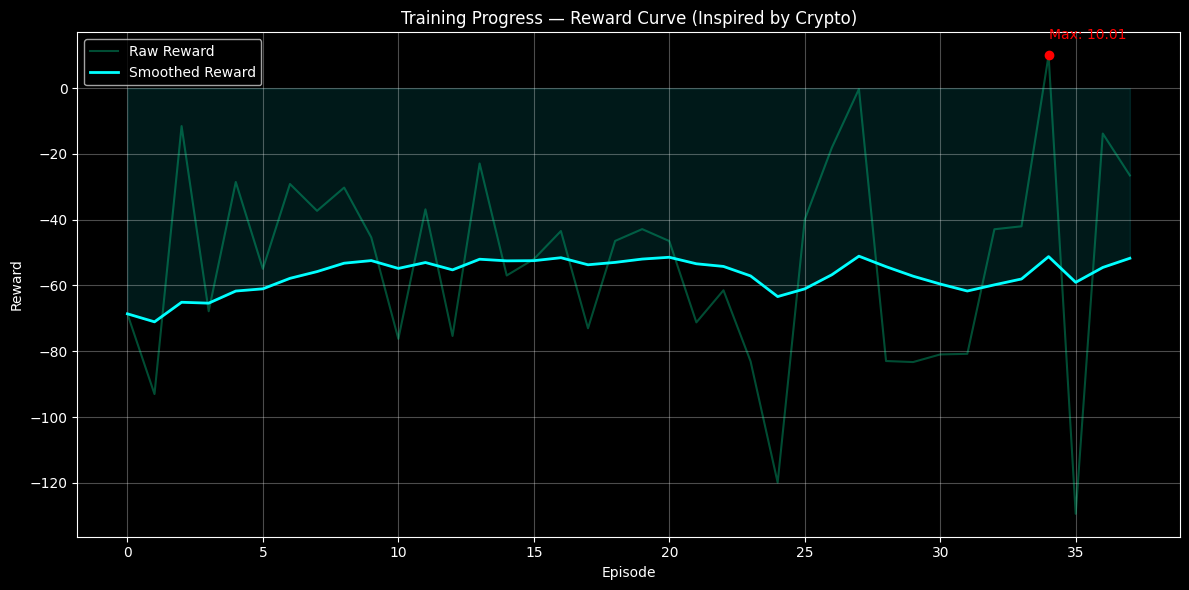

Episode: 38/1000, Score: -26.54
Top actions in this episode: [(np.int64(3), 145), (2, 29), (0, 25), (1, 21), (4, 18)]


In [ ]:
# ==== Test Frame Stack by Me ====

# ==== Build Target Network ====
target_model = build_model(input_shape=(96, 96, 12), action_size=5)
target_model.set_weights(model.get_weights())

# ==== Training Parameters ====
episodes = 1000 # More is good
batch_size = 128 # Minibatch size
gamma = 0.95 # Discount rate (~1 future is import)
max_step = 1000 # Max step per eposide
best_score = -np.inf

# ==== Before loop ====
steps = 0  # Initialize the steps

# ==== Record ====
rewards_per_episode = []

# ==== Clear memory to ensure consistent state shapes ====
# This prevents the ValueError if memory contains states from a non-stacked training run.
memory.clear()

# ==== Training Loop ====
for episode in range(episodes):
  env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)
  action_history = []

  state, _ = env.reset()

  # ==== 插入 No-op 動作 ====
  for _ in range(50):
      state, _, terminated, truncated, _ = env.step(0)
      if terminated or truncated:
          break

  # Initialize stacking: RGB version
  # Preprocess after no-op
  # ==== Preprocess  ====
  state = preprocess_frame(state, grayscale=False)
  frame_buffer = deque([state] * 4, maxlen=4)
  # ==== Stack State ====
  stacked_state = np.concatenate(list(frame_buffer), axis=-1)
  episode_reward =0.0


  # ==== Logic ====
  # state → select action → step in env → get next_state, reward → modify → store in memory

  for time in range(max_step):
    steps += 1  # Ensure epsilon dacay
    # Choose action using epsilon-greedy policy
    # act() → strategy
    # Use stacked state

    # ==== Force Forward ====
    if episode < 5 and time < 100:
      action = np.random.choice([1, 2, 3])
    else:
      action = act(stacked_state, rewards_per_episode)

    action_history.append(action)

    # Take action
    total_reward = 0
    # ==== Frame Skipping ====
    for _ in range(4):  # frame skip 次數
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward = total_reward + reward
        if terminated or truncated:
            break

    done = terminated or truncated

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    next_state = preprocess_frame(next_state, grayscale=False)
    frame_buffer.append(next_state)
    stacked_next_state = np.concatenate(list(frame_buffer), axis=-1)

    # Punish the stay
    reward = reward_shaping(action, total_reward, next_state, None)

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    # Remember
    # Store experience in memory
    # remember → memorize (replay buffer)
    remember(stacked_state, action, reward, stacked_next_state, done)

    # Update state
    stacked_state = stacked_next_state

    # Record reward
    episode_reward = episode_reward + float(reward)

    # If episode ends
    if done:
      eps_threshold_for_log = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      rewards_per_episode.append(episode_reward)
      plot_training_progress(rewards_per_episode)
      print(f"Episode: {episode+1}/{episodes}, Score: {episode_reward:.2f}")
      break

  #Train the model using replay memory
  replay_start = 5000  # 可調
  if len(memory) > replay_start and len(memory) > batch_size:
    double_replay(batch_size, episode=episode)

  # Reset Target Network
  if episode % 10 == 0:
    target_model.set_weights(model.get_weights())

  # Update Best Score
  if episode_reward > best_score:
    best_score = episode_reward
    model.save('best_model.keras')
    print(f"✅ New Best Score {best_score}")

  print("Top actions in this episode:", Counter(action_history).most_common())
  print("======================================")
  env.close()

print(f"Training complete after {episodes} episodes.")
print(f"Best model score: {best_score:.2f}")



In [ ]:
# ==== Visualize rewards_per_episode ===

import numpy as np
import matplotlib.pyplot as plt

def plot_rewards(rewards, threshold=500, smooth_weight=0.9, highlight_max=True, std_band=True):
    def smooth(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return np.array(smoothed)

    rewards = np.array(rewards)
    x = np.arange(len(rewards))
    smoothed = smooth(rewards, smooth_weight)
    std = np.std(rewards[-20:])  # 選最後 20 次 episode 的標準差

    plt.figure(figsize=(12, 6))

    # Plot 原始 Reward（淡灰）
    plt.plot(x, rewards, alpha=0.3, label='Raw Reward', color='gray')

    # Plot 平滑 Reward（藍色）
    plt.plot(x, smoothed, label='Smoothed Reward', color='blue', linewidth=2)

    # STD ±1 標準差區間（淡藍色區塊）
    if std_band:
        plt.fill_between(x, smoothed - std, smoothed + std, alpha=0.15, color='skyblue', label='±1 Std')

    # 500 baseline
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Pass Threshold ({threshold})')

    # Highlight max reward
    if highlight_max:
        max_idx = np.argmax(rewards)
        max_reward = rewards[max_idx]
        plt.scatter(max_idx, max_reward, color='darkorange', label='Max Reward')
        plt.text(max_idx, max_reward + 15, f'{max_reward:.1f}', ha='center', fontsize=9, color='darkorange')

    # Title and label
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress with Smoothed Curve and Std Band')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def scientific_plot(rewards, threshold=500, smooth_weight=0.9, highlight_max=True, std_band=True):
    def smooth(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
    # ==== Data ====
    rewards = np.array(rewards)
    x = np.arange(len(rewards))
    smoothed = smooth(rewards, smooth_weight)
    std = np.std(rewards[-20:])  # 選最後 20 次 episode 的標準差

    plt.figure(figsize=(12, 6))
    # ==== Label and Title ====
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress with Smoothed Curve and Std Band')

In [ ]:
scientific_plot(rewards_per_episode)

#### Non Stacked Frame Training Loop 不用 Stacked Frame 的訓練迴圈

In [ ]:
'''
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)


# ==== Build Target Network ====
target_model = build_model(input_shape=(96, 96, 3), action_size=5)
target_model.set_weights(model.get_weights())

# ==== Training Parameters ====
episodes = 1000 # More is good
batch_size = 128 # Minibatch size
gamma = 0.95 # Discount rate (~1 future is import)
max_step = 1000 # Max step per eposide
best_score = -np.inf

# ==== Before loop ====
steps = 0  # Initialize the steps
# ==== Training Loop ====
for episode in range(episodes):
  action_history = []
  state = env.reset()
  episode_reward =0.0

  if isinstance(state, tuple):
    state = state[0]

  # ==== Logic ====
  # state → select action → step in env → get next_state, reward → modify → store in memory

  for time in range(max_step):
    steps += 1  # Ensure epsilon dacay
    # Choose action using epsilon-greedy policy
    # act() → strategy
    action = act(state)
    action_history.append(action)

    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # Punish the stay
    reward = reward_shaping(action, reward, next_state, None)

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    # Remember
    # Store experience in memory
    # remember → memorize (replay buffer)
    remember(state, action, reward, next_state, done)

    # Update state
    state = next_state

    # Record reward
    episode_reward = episode_reward + float(reward)

    # If episode ends
    if done:
      print(f"Episode: {episode+1}/{episodes}, Score: {episode_reward:.2f}, Epsilon: {epsilon:.2f}")
      break

  #Train the model using replay memory
  replay_start = 5000  # 可調
  if len(memory) > replay_start and len(memory) > batch_size:
    double_replay(batch_size)

  # Test
  if episode % 10 == 0:
      test_env = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=False)
      obs, _ = test_env.reset()
      for _ in range(200):
          action = np.argmax(model.predict(obs[np.newaxis, ...], verbose=0)[0])
          obs, _, terminated, truncated, _ = test_env.step(action)
          if terminated or truncated:
              break
      test_env.close()

  # Reset Target Network
  if episode % 10 == 0:
    target_model.set_weights(model.get_weights())

  # Update Best Score
  if episode_reward > best_score:
    best_score = episode_reward
    model.save('best_model.keras')
    print(f"✅ New Best Score {best_score}")

  print("Top actions in this episode:", Counter(action_history).most_common())
  print("======================================")

print(f"Training complete after {episodes} episodes.")
print(f"Best model score: {best_score:.2f}")
env.close()
'''


# Evaluation

Episode: 1/10, Score: -94.07
Episode: 2/10, Score: -92.57
Episode: 3/10, Score: -74.91
Episode: 4/10, Score: -85.61
Episode: 5/10, Score: 756.85
Episode: 6/10, Score: 421.89
Episode: 7/10, Score: -85.61
Episode: 8/10, Score: 452.87
Episode: 9/10, Score: -92.78
Episode: 10/10, Score: 854.39
Evaluation complete after 10
Average Score: 196.05
Max Score: 854.39
Min Score: -94.07
Std Score: 367.13


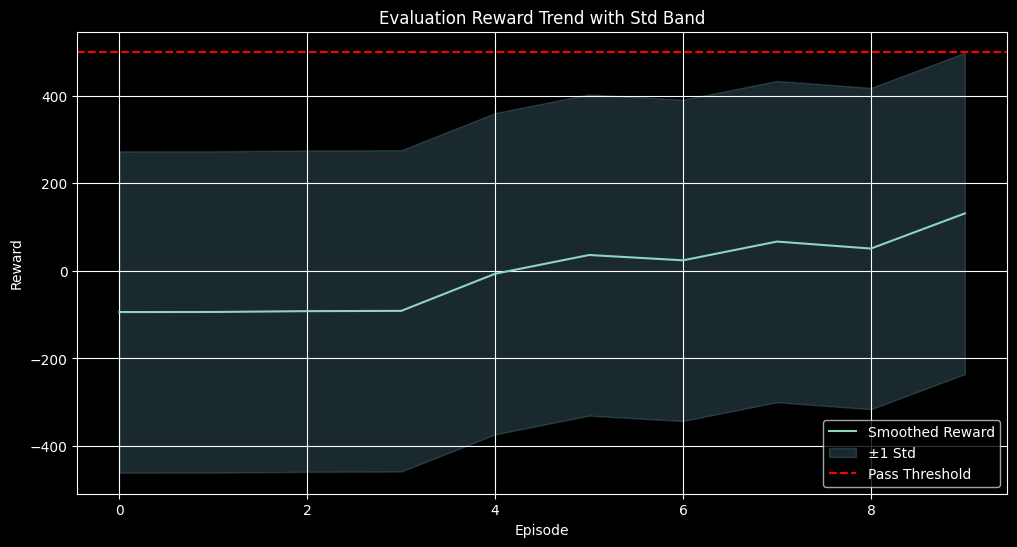

In [37]:
# Re-initialize the environment for evaluation
# Use the same parameters as the training environment

# ==== GIF file ====
output_dir = "/content/gifs"  # 你可以改成你要存的資料夾
os.makedirs(output_dir, exist_ok=True)  # 若不存在就創建資料夾

# ==== Evaluation ====
evaluation_episodes = 50 # Number of evaluation
score = []

# ==== Initialize Environment ====
env = gym.make("CarRacing-v3",
              render_mode= 'rgb_array',
              lap_complete_percent=0.95,
              domain_randomize=True,
              continuous=False)



for episode in range(evaluation_episodes):
  # ==== Make GIF ====
  gif_frames = []

  obs, _ = env.reset()
  frame = preprocess_frame(obs)

  # 初始化 frame buffer
  frame_buffer = deque([frame]*NUM_FRAMES, maxlen=NUM_FRAMES)
  stacked_state = np.concatenate(list(frame_buffer), axis=-1)  # shape: (96, 96, 12) if RGB

  total_reward = 0


  for time in range(max_step):
    gif_frames.append(env.render())

    # Step 1: 選 action（用 stacked_state）
    action = np.argmax(model.predict(stacked_state[np.newaxis, ...], verbose=0)[0])

    # Step 2: 與環境互動
    next_obs, reward, terminated, truncated, _ = env.step(action)

    # Step 3: 預處理 frame
    next_frame = preprocess_frame(next_obs)

    # Step 4: 更新 frame buffer + stacked_state
    frame_buffer.append(next_frame)
    stacked_state = np.concatenate(list(frame_buffer), axis=-1)

    # Step 5: 更新 reward 累加
    total_reward += float(reward)

    # Step 6: 檢查 done
    done = terminated or truncated
    if done:
        break

  score.append(total_reward)  # 加在這裡
  print(f"Episode: {episode+1}/{evaluation_episodes}, Score: {total_reward:.2f}")
  gif_path = os.path.join(output_dir, f"episode_{episode+1:03d}.gif")
  imageio.mimsave(gif_path, gif_frames, fps=30)

env.close()

# ==== Scores ====
average_score = np.mean(score)
max_score = np.max(score)
min_score = np.min(score)
std_score = np.std(score)

print(f'Evaluation complete after {evaluation_episodes}')
print(f"Average Score: {average_score:.2f}")
print(f"Max Score: {max_score:.2f}")
print(f"Min Score: {min_score:.2f}")
print(f"Std Score: {std_score:.2f}")

# ==== Visualization ====
def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

smoothed = smooth(score)
std = np.std(score)

# ==== Plot ====
plt.figure(figsize=(12, 6))

# ==== Use White Background ====
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

x = np.arange(len(score))

plt.plot(x, score, label='Raw Reward', alpha=0.3)

plt.plot(x, smoothed, label='Smoothed Reward', linewidth=2)

# ==== Std Band ====

plt.fill_between(x, smoothed - std, smoothed + std, alpha=0.2, color='skyblue', label='±1 Std')

# ==== Baseline ====
plt.axhline(y=500, color='red', linestyle='--', label='Pass Threshold')

# ==== Title and label ====
plt.title('Evaluation Reward Trend with Std Band')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid()
plt.show()

